# MA934  Numerical Methods - Workbook 2

In [1]:
using Plots
pyplot()
include("kvpair.jl")
include("llist.jl")
include("ftree.jl")

buildFTree (generic function with 1 method)

## Question 1: Linear search using a linked list

The file KVPair.jl defines a simple data structure to represent an (Int64, Float64) key-value pair. 

The file LList.jl defines a linked list that stores a KVPair at each node. Many languages have a keyword NULL. A pointer to any object can take the value NULL to indicate that it doesn't point to anything. NULL is often used to denote the end of a list, the leaves of a tree etc. Julia does not support NULL pointers. This causes a difficulty in implementing recursive data structures. Instead Julia provides a parametric data type Nullable{T} to represent missing values. It is possible to use Nullable types to define recursive data structures although some of the resulting definitions are a bit clumsy. I'm not sure that this is the canonical way to implement structural recursion in Julia. 

The following points are important:

* if a variable has type Nullable{T} then it can either contain a value of type T or nothing (ie a missing value). 
* the function isnull(x) checks whether a nullable type x has a value or not. 
* the function get(x) returns the actual value (of type T) contained in a nullable type x.

Much more information can be found at https://docs.julialang.org/en/stable/manual/types/

The function 

> buildLList(dataArray::Array{KVPair, 1})

takes an array of KVPair objects as input and returns an LList containing these KVPairs. This is illustrated in the code below.

1. Write a recursive function that traverses the list and prints out the key-value pairs stored in it. Check that your function works.
2. Write a function search(list::Nullable{LList}, k::Int64) that searches an LList for the key k and returns the corresponding KVPair if it is present and a Nullable{KVPair} otherwise. Verify that your function works.
3. Use Julia's @timed macro to measure how the typical computational cost of your search() function grows with the length of the list. 

In [240]:
include("workbook2_function.jl")
N = 10 #checks the function works for list of length N
seed = 3300
rng = MersenneTwister(seed)
X = rand(rng, N)
values = Array{KVPair}(N)
for i = 1:N
    values[i] = KVPair(i,X[i])
end

L = Nullable{LList}()
L = buildLList(values);

keyvaluepairs(L) #prints out KVPairs for a list of lenght N

KVPair(1,0.9106712863152586)
KVPair(2,0.4346829146136031)
KVPair(3,0.38589111518347363)
KVPair(4,0.9246032540129225)
KVPair(5,0.6311166586789221)
KVPair(6,0.8574998337247581)
KVPair(7,0.961579117947865)
KVPair(8,0.36612288307618823)
KVPair(9,0.8202584768844892)
KVPair(10,0.5197000283055662)


In [231]:
search(L, 4) #for list above it searches for the key value 4 and returns the KVPair

KVPair(4,0.9246032540129225)

In [232]:
times_mean = zeros(500) #lists of length up to 500
for i =1:500
    NN = i
    time = zeros(NN) #time temporaily stores the time taken to find every possible key value in that list
    XX = rand(rng, NN)
    VV = Array{KVPair}(NN) #generates a list of length NN 
    for l = 1:NN
        VV[l] = KVPair(l,XX[l])
    end
    LL = Nullable{LList}()
    LL = buildLList(VV)
    for k =1:NN
        time[k] = (@timed search(LL, k))[2]
    end
    times_mean[i] = mean(time) #mean time it takes to find any key value in a given list of length NN
end


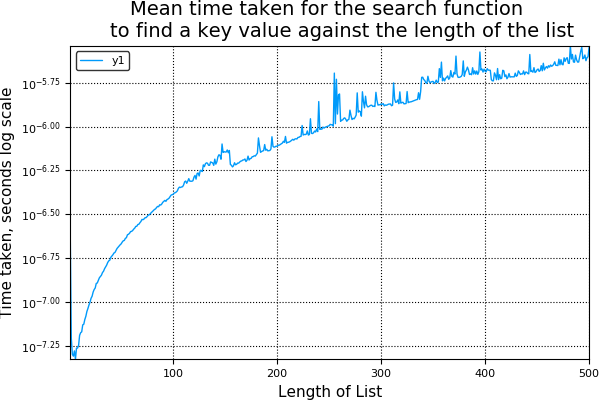

In [270]:
using Plots
pyplot()
plot(1:500, times_mean, xlabel = "Length of List", ylabel = "Time taken, seconds log scale", 
    title = "Mean time taken for the search function 
    to find a key value against the length of the list", yaxis = :log)

## Question 2: Interval membership

The problem of interval membership is the following: given a set of contiguous intervals, 

$\left\{[x_0, x_1), [x_1, x_2), \ldots, [x_{n-2}, x_{n-1}), [x_{n-1}, x_n)\right\}$

spanning the interval $[x_1, x_n)$ and given a random number $x \in [x_1, x_n)$, determine the interval in which $x$ lies. The standard numerical algorithm for stochastic simulation of continuous-time Markov processes (eg birth-death process, contact process, SIR model etc) requires solving an interval membership problem at each time step. It is therefore important to be able to solve it efficiently. Note, we cannot assume that all intervals are the same length.

We can solve the interval membership problem with $n$ interval by a variant of linear search in $O(n)$ time. We will demonstrate below that it can be solved in $O(\log\, n)$ time using a variant of a data structure known as a Fenwick tree.

**1)** Use Julia's random number generator to generate $n$ random interval lengths, $y_1, y_2, \ldots, y_n$ between 0 and 1 as shown: 

In [236]:
n=10 #number of intervals
Y = rand(rng, n); #intervals each between 0 and 1

In [242]:
x = zeros(n)
for j = 1:n
    x[j] = sum(Y[1:j]) #finds the cumulative sum 
end

key_val = Array{KVPair}(n) #generates the linked list
for k = 1:n
    key_val[k] = KVPair(k,x[k])
end

Linked = Nullable{LList}()
Linked = buildLList(key_val)
keyvaluepairs(Linked) #prints the KVPairs of the list

KVPair(1,0.5802578360807791)
KVPair(2,1.300077582561761)
KVPair(3,1.5244523773336254)
KVPair(4,2.062447444257102)
KVPair(5,3.026294762461893)
KVPair(6,3.516416416020619)
KVPair(7,4.375713341483044)
KVPair(8,4.414019550760885)
KVPair(9,4.552574082403461)
KVPair(10,4.81141933748007)


The corresponding interval membership problem is constructed from the partial sums:
$$x_i = \sum_{j=1}^i y_j, \ \ \ \ \ i=1,2,\ldots n.$$ 
Using the objects defined in KVPair.jl and LList.jl, create an array of key-value pairs, $(i, x_i)$, associating each interval with the corresponding partial sum and store this array in a linked list. Print the list for a small value of $n$to verify that it works.

**2)** Modify the search function you wrote above to write a recursive function

$$\text{intervalmembership(list::Nullable{LList}, x::Float64)}$$

that takes the LList containing the list of partial sums and a random Float64 in the range $[0, x_n]$ as inputs and returns the KVPair corresponding to the interval in which $x$ lies. Verify that it works for small values of $n$ and use Julia's @timed macro to measure how the typical computational cost grows with $n$. 

**3)** The file FTree.jl defines a data structure implementing a variant of a Fenwick tree that can solve the interval membership problem as described in the lectures/notes. The function 

$$\text{buildFTree(T::Nullable{FTree}, dataArray::Array{KVPair, 1})}$$

takes the array of KVPairs containing the interval lengths as input, recursively constructs the tree and returns the FTree containing the correct key-value pairs (note a key of -1 is assigned to all non-leaf nodes).

In [250]:
intervalmembership(Linked,4.2) #for the above list returns the KVPair that x = 4.2 lies in

KVPair(7,4.375713341483044)

In [251]:
timed = zeros(13) #finds the time taken for intervalmembership to run for lists of sizes 2^0 to 2^{12}
for i = (0:12)
    nn = 2.^(i)
    time_1 = zeros(nn)
    yy = rand(rng, nn)
    xx = cumsum(yy)
    kval = Array{KVPair}(nn)
    for k = 1:nn
        kval[k] = KVPair(k,xx[k])
    end
    ll = Nullable{LList}()
    ll = buildLList(kval)
    x_nn = search(ll, nn).value #finds the last value of the list as this is the interval [0,x_nn]
    for j = 1:nn
        for k in linspace(0.0, x_nn, 1000) #runs program for 1000 values between [0,1000]
            time_1[j]= (@timed intervalmembership(ll, k))[2]
        end
    end
    timed[i+1] = mean(time_1)
end



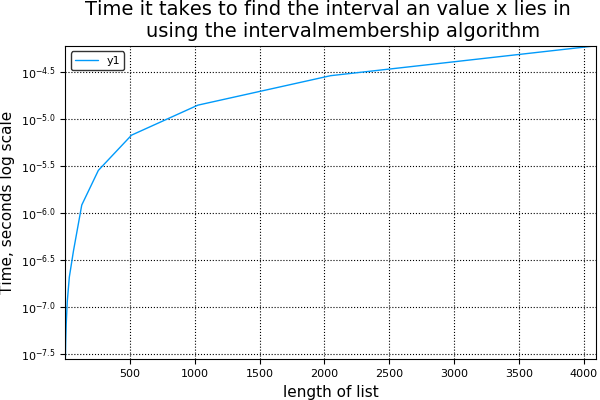

In [271]:
plot(2.^(0:12), timed, ylabel = "Time, seconds log scale", xlabel = "length of list",
    title = "Time it takes to find the interval an value x lies in 
    using the intervalmembership algorithm", yaxis = :log)

In [259]:
n=5
X = rand(rng, n)
values = Array{KVPair}(n)
for i = 1:n #for trees we DON'T input the cumulative frequency
    values[i] = KVPair(i,X[i])
end
T = Nullable{FTree}(FTree(KVPair(0,0.0))) #builds the tree
T=buildFTree(T, values);

Write a recursive function

$$\text{intervalmembership(FT::Nullable{FTree}, x::Float64)}$$

that takes the FTree containing the list of partial sums and a random Float64 in the range $[0, x_n]$ as 
inputs and returns the KVPair corresponding to the interval in which $x$ lies. Verify that it works for small values of $n$ and use Julia's @timed macro to compare how the typical computational compares to the above linear search version. Note it can sometimes be difficult to directly measure $O(\log\, n)$ growth in computation time since the problem size needs to become very large to register appreciable run times.

In [260]:
# test function
intervalmembership1(T, 1.2) #uses a Fenwick tree to find the interval x=1.2 lies in

KVPair(3,0.2278682366582676)

In [261]:
timed_2 = zeros(13)
for i = (0:12) #again uses 2^i for the length of each interval
    nn = 2.^(i)
    time_2 = zeros(nn)
    yy2 = rand(rng, nn)
    y_nn=sum(yy2) #maximum of the interval [0,y_nn]
    kval2 = Array{KVPair}(nn)
    for k = 1:nn
        kval2[k] = KVPair(k,yy2[k])
    end
    tt = Nullable{FTree}(FTree(KVPair(0,0.0)))
    tt =buildFTree(tt, kval2)
    for j = 1:nn
        for k in linspace(0.0, y_nn, 1000)
            time_2[j]= (@timed intervalmembership1(tt, k))[2]
        end
    end
    timed_2[i+1] = mean(time_2)
end

In [263]:
# timed_3 = zeros(1000)
# for i = (1:1000)
#     nn = i
#     time_3 = zeros(nn)
#     yy3 = rand(rng, nn)
#     y_nn1 = sum(yy3)
#     kval3 = Array{KVPair}(nn)
#     for k = 1:nn
#         kval3[k] = KVPair(k,yy3[k])
#     end
#     tt1 = Nullable{FTree}(FTree(KVPair(0,0.0)))
#     tt1 =buildFTree(tt1, kval3)
#     for j = 1:nn
#         for k in linspace(0.0, y_nn1, 1000)
#             time_3[j]= (@timed intervalmembership1(tt1, k))[2]
#         end
#     end
#     timed_3[i] = mean(time_3)
# end


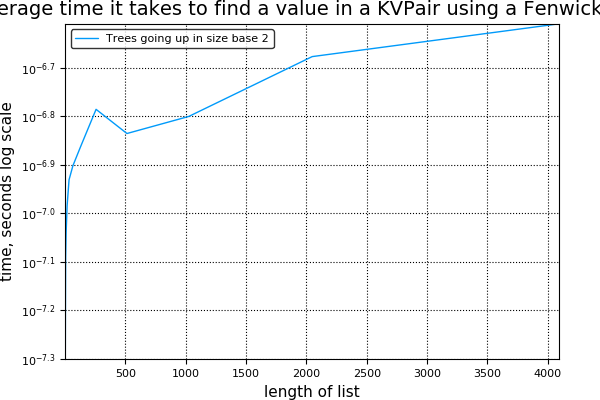

In [267]:
plot(2.^(0:12), timed_2, yaxis = :log, xaxis = :none, ylabel = "time, seconds log scale", xlabel = "length of list",
title = "Average time it takes to find a value in a KVPair using a Fenwick Tree", label = "Trees going up in size base 2")
# plot!(1:1000, timed_3, yaxis = :log, xaxis = :none, label = "Trees of size 0 to 1000")

## Question 3: Gillespie algorithm for heterogeneous diffusion

The Gillespie algorithm is a dynamic Monte Carlo algorithm that generates statistically correct realisations of a continous time Markov process. See https://en.wikipedia.org/wiki/Gillespie_algorithm It is used heavily in stochastic simulation of chemical and biological reaction networks and population dynamics. In this question we use it to simulate one-dimensional diffusion of heterogeneous particles whose diffusion constants are independently drawn from an exponential distribution.

The basic idea of the algorithm is as follows
1. Create a list $\left\{(i, r_i), i=1,\ldots M\right\}$,  of all possible transitions (events), $i$, that can occur in the system and the corresponding transition rates, $r_i$.
2. Calculate the total rate
$$R = \sum_{i=1}^M r_i$$
and divide the interval $[0, R]$ into $M$ intervals whose lengths are given by the $r_i$.
3. Generate a uniform random number in the range $[0,R]$ and determine which interval it falls in. 
4. Perform the corresponding transition and update the time variable by an amount $\Delta t = 1/R$.
5. Repeat until the desired simulation time is reached.

To be concrete, suppose with have $N$ particles on the interval $[-L, L]$ initially located at $x=0$. Each particle can hop a distance $\Delta x$ to the left or to the right with equal probability. The rate of hopping is initially considered to be the same for all particles:

$$ r_i = \frac{D}{2}\,\frac{1}{(\Delta x)^2} $$

This choice ensures that in the continous limit ($\Delta x \to 0$, $N\to \infty$), the density of particles $c(x,t)$ on the line will satisfy the usual diffusion equation with diffusion coefficient $D$ (recall MA933):

$$ \frac{\partial c}{\partial t} = D \frac{\partial^2 c}{\partial x^2}$$

with initial condition $c(x,0) = \delta(x)$.

The steps of the algorithm then correspond to the following:
1. There are $M= 2 N$ possible transitions at each step: each of $N$ particles can hop a distance $\Delta x$ either left or right with the above rates. We index them as follows: events k=1:N correspond to particle k hopping to the right, events k=N+1:2N correspond to particle k-N hopping to the left.
2. The total rate is 
$$ R = \frac{D N}{(\Delta x)^2}.$$
3. Generate a uniform random number in the range $[0,R]$ and determine the index $k$ of particle to move and the direction.
4. Update the position of particle $k$ accordingly.
5. Repeat.

The following piece of code implements the Gillespie algorithm for N=100, L=10, $\Delta x = 0.1$ and $D=1$, converts the particle positions to particle density and compares to the solution of the diffusion equation on an unbounded domain at t=1 (we assume that L=10 is far enough from zero to be considered unbounded):

$$c(x, t) = \frac{1}{\sqrt{2 \pi D t}}\, \exp [-\frac{1}{2}\frac{x^2}{D t} ]$$


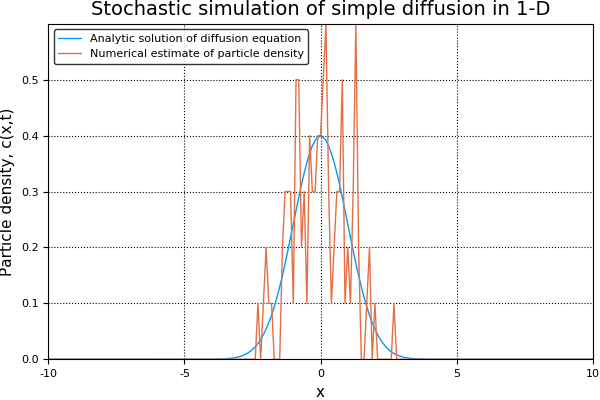

In [51]:
L=10.0
N=100
Nx = 201
dx = 2.0*L/(Nx-1)
X = dx.*(-(Nx-1)/2:(Nx-1)/2)
Y =zeros(Int64,N) #initially all particles are at N, this will be filled with their states (integers)
D = 1.0
t=0.0

r = (D)./(2.0*dx*dx)
totalRate = 2.0*N*r
dt = 1.0/totalRate
T=1.0

# This is the main loop
while t < T
    # Pick an event
    k = rand(1:2*N) 
    if k<=N
        hop = 1
        particleId = k
    else
        hop = -1
        particleId=k-N
    end
    Y[particleId]+=hop
    t+=dt
end

# Calculate the estimated density of particles
P =zeros(Float64,length(X))
for i in 1:length(Y)
    P[Y[i]+Int64((Nx-1)/2)+1]+=1/(N * dx)
end

# Calculate the theoretical density and compare
function normal(x, D, t)
    return (1.0/sqrt(2.0*pi*D*t))*exp(-x*x/(2*D*t))
end
P1 = normal.(X, D, T)
plot(X, P1, label="Analytic solution of diffusion equation")
plot!(X, P, label="Numerical estimate of particle density")
xlabel!("x")
ylabel!("Particle density, c(x,t)")
title!("Stochastic simulation of simple diffusion in 1-D")

**1)** The code above makes critical use of the fact that all intervals have the same width in order to decide which particle to move at each step. Suppose now that instead of being equal to $D$ for each particle, the diffusion coefficients are drawn from an exponential distribution with mean $D$:

$$ P(x) = \frac{1}{D} \exp\left(-\frac{x}{D}\right). $$

Modify the code to account for this, using your code from Q2 above to solve the interval membership problem using linear search. You will need to use Julia's randexp() function to generate values for the diffusion coefficients. What is the largest value of $N$ you can simulate in a "reasonable" time?

**2)** Try again using your Fenwick tree from Q2 to solve the interval membership problem and compare. What is the largest value of $N$ you can simulate now?

**3)** Show analytically that the solution of the heterogenous diffusion problem is

$$ c(x,t) = \frac{\exp \left(-\sqrt{\frac{2}{D\,t}}\, |x| \right)}{\sqrt{2\, D\, t}}$$

You will probably need the integral formula (Formula 3.325 of Gradshteyn and Rizhik, 7th Ed.)

$$ \int_0^\infty \exp\left(-a\,x^2 - \frac{b}{x^2} \right)\, dx =  \frac{1}{2}\,\sqrt{\frac{\pi}{a}}\,\exp\left(-2 \sqrt{a\,b} \right).$$
Use this formula to validate your numerical results.



Question 3.3:

Now D is a random exponentially distributed variable. So we can say the solution to the heterogenous diffusion problem is the expected value of the homogenous diffusion solution with the random variable D: $$<c(x,t)> = \int_{0}^{\infty} dy \frac{1}{D} e^{-\frac{y}{D}} \left( \frac{1}{\sqrt{2 \pi y t}} e^{-\frac{x^2}{2yt}} \right) $$
Then using the subsitution $y = z^2$, $<c(x,t)> = \frac{2}{D \sqrt{2 \pi t}} \int_{0}^{\infty} dz \ z \ z^{-1} e^{-\frac{z^2}{D}-\frac{x^2}{2z^2t} }$. then by the above formula,  $<c(x,t)> = \frac{1}{ \sqrt{2 D t}}  exp({-\frac{2 |x|}{\sqrt{2Dt}}})$.

time to run = 4.265681764 seconds for N = 1000



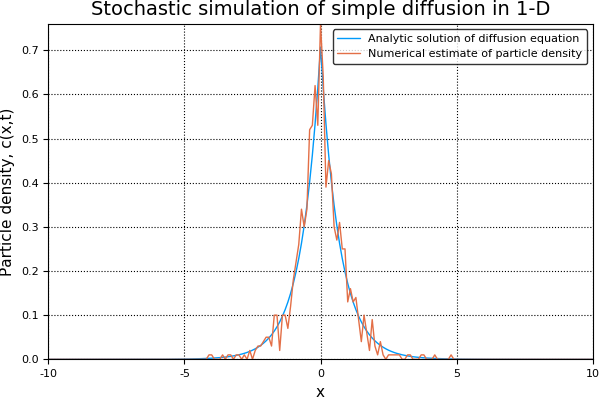

In [217]:
L=10.0
N=1000 #1000 particles 
Nx = 201 #201 possible states
dx = (2.0*L)/(Nx-1)
X = dx.*(-(Nx-1)/2:(Nx-1)/2)
Y =zeros(Int64,N) #initially all particles are at 0, this will be filled with their states (integers)
t=0.0
D = 1
rate = randexp(N)
Rate_2 = vcat(rate, rate)*(1/(2*((dx)^2))) #vcat as rate of going forward is equal to the rate of going back 
totalRate = sum(Rate_2)
dt = 1.0/(totalRate)
T=1

RR = cumsum(Rate_2) #cumulative frequency to use the intervalmembership on lists algorithm 

value_r = Array{KVPair}(2*N)
for k = 1:2*N
    value_r[k] = KVPair(k,RR[k])
end

Llist_rates = Nullable{LList}()
Llist_rates= buildLList(value_r)


# This is the main loop
time = @timed while t < T
    K = totalRate*rand() #choose event/rate
    interval = intervalmembership(Llist_rates, K)
    particle = interval.key #key returns which particle will be moved 
    if particle<=N
        hop = 1 
        particleId = particle
    else
        hop = -1
        particleId=particle-N
    end
    Y[particleId]+=hop
    t+=dt
end


# Calculate the estimated density of particles
P =zeros(Float64,length(X))
for i in 1:length(Y)
    P[Y[i]+Int64((Nx-1)/2)+1]+=1/(N * dx)
end

function hetergenousdiffusion(x,d,t) #hetergeneous difussion problem 
    return ((1.0/sqrt(2*d*t))*exp(-(sqrt(2/(d*t)))*abs(x)))
end
P2 = hetergenousdiffusion.(X, D, T)

println("time to run = $(time[2]) seconds for N = $N")
plot(X, P2, label="Analytic solution of diffusion equation")
plot!(X, P, label="Numerical estimate of particle density")
xlabel!("x")
ylabel!("Particle density, c(x,t)")
title!("Stochastic simulation of simple diffusion in 1-D")

time to run is 15.218395759 seconds where N = 100000



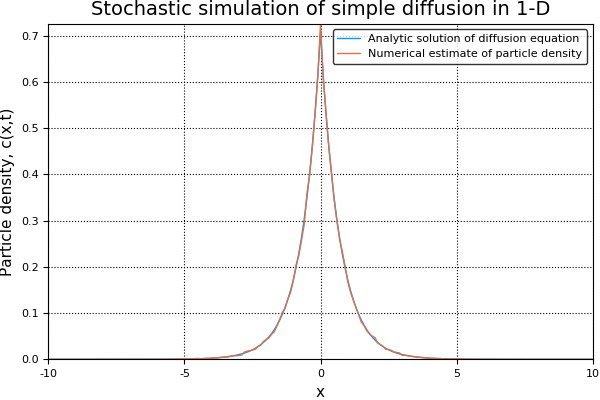

In [275]:
L=10.0
N=100000
Nx = 201
dx = (2.0*L)/(Nx-1)
X = dx.*(-(Nx-1)/2:(Nx-1)/2)
Y =zeros(Int64,N) #initially all particles are at 0, this will be filled with their states (integers)
t=0.0
D = 1.0
rate =randexp(N)
Rate_2 = vcat(rate, rate)*(1/(2*((dx)^2)))
totalRate = sum(Rate_2)
dt = 1.0/(totalRate)
T=1

value_r = Array{KVPair}(2*N)
for k = 1:2*N
    value_r[k] = KVPair(k,Rate_2[k])
end

tTree = Nullable{FTree}(FTree(KVPair(0,0.0)))
tTree=buildFTree(tTree, value_r)


# This is the main loop
time = @timed while t < T
    # Pick an event
    K = totalRate*rand() #choose event
    interval = intervalmembership1(tTree, K)
    particle = interval.key
    if particle<=N
        hop = 1
        particleId = particle
    else
        hop = -1
        particleId=particle-N
    end
    Y[particleId]+=hop
    t+=dt
end

# Calculate the estimated density of particles
P =zeros(Float64,length(X))
for i in 1:length(Y)
    P[Y[i]+Int64((Nx-1)/2)+1]+=1/(N * dx)
end

println("time to run is $(time[2]) seconds where N = $N")
P2 = hetergenousdiffusion.(X, 1.0, T)
plot(X, P2, label="Analytic solution of diffusion equation")
plot!(X, P, label="Numerical estimate of particle density")
xlabel!("x")
ylabel!("Particle density, c(x,t)")
title!("Stochastic simulation of simple diffusion in 1-D")